# Reconstruction vs detection tradeoff

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
SPLIT = 3
SEEDS = list(range(5))

In [ ]:
CN_METRICS = ["MSE_with_input", "SSIM_with_input"]
AD_METRICS = [
    "MSE_with_true_healthy",
    "SSIM_with_true_healthy",
    "AveragePrecision",
    "BestDice",
]

COLUMNS = (
    [
        "participant_id",
        "session_id",
        "beta",
        "latent_size",
        "seed",
    ]
    + CN_METRICS
    + AD_METRICS
)

## Beta VAE

If you intend to use this notebook, you need to change all the paths below

In [ ]:
root_path = Path(
    "SET THE PATH"
)
beta_vae_paths = {
    (0.1, 20): root_path / "2025-10-29_13-54-01" / "beta_0.1/lalpha_0.0/latent_dim_20",
    (0.1, 64): root_path / "2025-10-20_15-38-39" / "beta_0.1/lalpha_0.0/latent_dim_64",
    (0.1, 256): root_path
    / "2025-10-29_13-54-01"
    / "beta_0.1/lalpha_0.0/latent_dim_256",
    (1, 20): root_path / "2025-10-20_15-38-39" / "beta_1/lalpha_0.0" / "latent_dim_20",
    (1, 64): root_path / "2025-10-20_15-38-39" / "beta_1/lalpha_0.0" / "latent_dim_64",
    (1, 256): root_path
    / "2025-10-20_15-38-39"
    / "beta_1/lalpha_0.0"
    / "latent_dim_256",
    (10, 20): root_path
    / "2025-10-23_14-56-36"
    / "beta_10/lalpha_0.0"
    / "latent_dim_20",
    (10, 64): Path(
        "vae_64_10/2025-10-16_16-49-05/beta_10.0"
    ),
    (10, 256): root_path
    / "2025-10-23_14-56-36"
    / "beta_10/lalpha_0.0"
    / "latent_dim_256",
    (100, 20): root_path / "2025-10-29_11-18-25/beta_100/lalpha_0.0" / "latent_dim_20",
    (100, 64): root_path / "2025-10-29_11-18-25/beta_100/lalpha_0.0" / "latent_dim_64",
    (100, 256): root_path / "2025-10-29_11-18-25"
    "/beta_100/lalpha_0.0" / "latent_dim_256",
}

In [ ]:
beta_vae_dfs = pd.DataFrame(columns=COLUMNS)

for (beta, d), path in beta_vae_paths.items():
    if path is None:
        continue
    for seed in SEEDS:
        if (beta, d, seed) == (10, 64, 4):
            continue

        # Retrieve model
        seed_path = Path(path, f"split_{SPLIT}", f"seed_{seed}")
        model_paths = list(seed_path.glob("CVAE_training_*/final_model"))
        if len(model_paths) > 1:
            raise AssertionError(f"More than one trained model in {seed_path}")
        elif len(model_paths) == 0:
            raise AssertionError(f"No trained model in {seed_path}")
        trained_model_path = model_paths[0]

        # Retrieve CN metrics
        cn_csv_path = trained_model_path / "test_cn_baseline" / "metrics_on_test.csv"
        cn_df = pd.read_csv(cn_csv_path, index_col=0)
        current_df = cn_df[["participant_id", "session_id"] + CN_METRICS].copy()

        # Retrieve AD metrics
        ad_30_csv_path = trained_model_path / "test_AD_30" / "metrics_on_test.csv"
        ad_30_df = pd.read_csv(ad_30_csv_path, index_col=0)
        for ad_metric in AD_METRICS:
            current_df[ad_metric] = ad_30_df[[ad_metric]].values

        # Compute rMSE
        current_df.set_index(["participant_id", "session_id"], inplace=True)
        current_df["rMSE"] = (
            current_df["MSE_with_true_healthy"] / current_df["MSE_with_input"]
        )
        current_df.reset_index(inplace=True)

        # Set beta, latent and seed
        current_df["beta"] = beta
        current_df["latent_size"] = d
        current_df["seed"] = seed

        # Concat
        beta_vae_dfs = pd.concat([beta_vae_dfs, current_df], ignore_index=True)

/tmp/ipykernel_3023615/1496935900.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  beta_vae_dfs = pd.concat([beta_vae_dfs, current_df], ignore_index=True)


In [ ]:
nbs = beta_vae_dfs.groupby(["beta", "latent_size"]).size()
beta_vae_metrics = beta_vae_dfs.groupby(["seed", "beta", "latent_size"]).mean(
    numeric_only=True
)
beta_vae_means = beta_vae_metrics.groupby(["beta", "latent_size"]).mean().reset_index()
beta_vae_stds = (
    beta_vae_metrics.groupby(["beta", "latent_size"])
    .std(numeric_only=True)
    .reset_index()
)
print(nbs)

beta   latent_size
0.1    20             250
       64             250
       256            250
1.0    20             250
       64             250
       256            250
10.0   20             250
       64             200
       256            250
100.0  20             250
       64             250
       256            250
dtype: int64


## Sparse VAE 

In [ ]:
root_sparse_path = Path(
    "SET THE PATH/sparse_vae_seeds"
)
sparse_vae_paths = {
    -2: root_sparse_path / "2025-10-26_14-56-06/beta_1.0",
    -3: root_sparse_path / "2025-10-29_10-52-27/beta_1.0/lalpha_-3.0",
}

In [ ]:
sparse_vae_dfs = pd.DataFrame(columns=COLUMNS)

for lalpha, path in sparse_vae_paths.items():
    for seed in SEEDS:
        # Retrieve model
        seed_path = Path(path, f"split_{SPLIT}", f"seed_{seed}")
        model_paths = list(seed_path.glob("CVAE_training_*/final_model"))
        if len(model_paths) > 1:
            raise AssertionError(f"More than one trained model in {seed_path}")
        elif len(model_paths) == 0:
            raise AssertionError(f"No trained model in {seed_path}")
        trained_model_path = model_paths[0]

        # Retrieve CN metrics
        cn_csv_path = trained_model_path / "test_cn_baseline" / "metrics_on_test.csv"
        cn_df = pd.read_csv(cn_csv_path, index_col=0)
        current_df = cn_df[["participant_id", "session_id"] + CN_METRICS].copy()

        # Retrieve AD metrics
        ad_30_csv_path = trained_model_path / "test_AD_30" / "metrics_on_test.csv"
        ad_30_df = pd.read_csv(ad_30_csv_path, index_col=0)
        for ad_metric in AD_METRICS:
            current_df[ad_metric] = ad_30_df[[ad_metric]].values

        # Compute rMSE
        current_df.set_index(["participant_id", "session_id"], inplace=True)
        current_df["rMSE"] = (
            current_df["MSE_with_true_healthy"] / current_df["MSE_with_input"]
        )
        current_df.reset_index(inplace=True)

        # Set beta, latent and seed
        current_df["lalpha"] = lalpha
        current_df["seed"] = seed

        # Concat
        sparse_vae_dfs = pd.concat([sparse_vae_dfs, current_df], ignore_index=True)

/tmp/ipykernel_3023615/1134446978.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sparse_vae_dfs = pd.concat([sparse_vae_dfs, current_df], ignore_index=True)


In [ ]:
nbs = sparse_vae_dfs.groupby(["lalpha"]).size()
sparse_vae_metrics = sparse_vae_dfs.groupby(["seed", "lalpha"]).mean(numeric_only=True)
sparse_vae_means = sparse_vae_metrics.groupby(["lalpha"]).mean().reset_index()
sparse_vae_stds = (
    sparse_vae_metrics.groupby(["lalpha"]).std(numeric_only=True).reset_index()
)
print(nbs)

lalpha
-3.0    250
-2.0    250
dtype: int64


## Plots

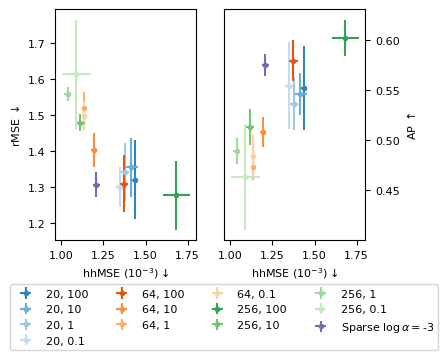

In [ ]:
xmetric = "MSE_with_input"
ymetric = "rMSE"

colors = plt.cm.tab20c(np.arange(20).astype(int))

fig, ax = plt.subplots(1, 2, figsize=(4, 3))

for j, ymetric in enumerate(["rMSE", "AveragePrecision"]):
    i = 0
    for latent_size in [20, 64, 256]:
        for beta in [100, 10, 1, 0.1]:
            ax[j].errorbar(
                x=beta_vae_means[
                    (beta_vae_means["beta"] == beta)
                    & (beta_vae_means["latent_size"] == latent_size)
                ][xmetric]
                * (10**3),
                y=beta_vae_means[
                    (beta_vae_means["beta"] == beta)
                    & (beta_vae_means["latent_size"] == latent_size)
                ][ymetric],
                xerr=beta_vae_stds[
                    (beta_vae_stds["beta"] == beta)
                    & (beta_vae_stds["latent_size"] == latent_size)
                ][xmetric]
                * (10**3),
                yerr=beta_vae_stds[
                    (beta_vae_stds["beta"] == beta)
                    & (beta_vae_stds["latent_size"] == latent_size)
                ][ymetric],
                fmt=".",
                label=f"{latent_size}, {beta}",
                color=colors[i],
            )
            i += 1

    for lalpha in [-3]:
        ax[j].errorbar(
            x=sparse_vae_means[(sparse_vae_means["lalpha"] == lalpha)][xmetric]
            * (10**3),
            y=sparse_vae_means[(sparse_vae_means["lalpha"] == lalpha)][ymetric],
            xerr=sparse_vae_stds[(sparse_vae_stds["lalpha"] == lalpha)][xmetric]
            * (10**3),
            yerr=sparse_vae_stds[(sparse_vae_stds["lalpha"] == lalpha)][ymetric],
            fmt=".",
            label=r"Sparse $\log\alpha=$" + str(lalpha),
            color=colors[i],
        )
        i += 1

    ax[j].set_xlabel(r"hhMSE $(10^{-3}) \downarrow$", fontsize=8)
    ax[j].set_ylabel(
        r"rMSE $\downarrow$" if ymetric == "rMSE" else r"AP $\uparrow$", fontsize=8
    )
    # ax[j].ticklabel_format(axis='x', style='sci', scilimits=(-3, -3))
    ax[j].tick_params(axis="both", labelsize=8)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

# plt.legend(ncols=4, loc="lower center", bbox_to_anchor=(0, -0.5), fontsize=8)
# plt.savefig(f"scatterplot_with_legend.svg", bbox_inches="tight")

plt.savefig("scatterplot.svg", bbox_inches="tight")
